# MediaPipe Pose Detection Demo

This notebook demonstrates MediaPipe pose detection on video frames:
1. Select 4 videos from the `video-data/` directory
2. Extract a single frame from each video
3. Run MediaPipe pose detection on each frame
4. Overlay the detected landmarks on the frames

In [1]:
import os
import urllib.request

import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python as mp_tasks
from mediapipe.tasks.python import vision

## Setup: Download MediaPipe Model (if needed)

In [2]:
MODEL_PATH = ".models/pose_landmarker_heavy.task"

def ensure_model_exists():
    """Download the MediaPipe pose landmarker model if not present."""
    if not os.path.exists(MODEL_PATH):
        os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
        url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task"
        print(f"Downloading model to {MODEL_PATH}...")
        urllib.request.urlretrieve(url, MODEL_PATH)
        print("Download complete.")
    else:
        print(f"Model already exists at {MODEL_PATH}")

ensure_model_exists()

Model already exists at .models/pose_landmarker_heavy.task


## Select 4 Videos from the Dataset

In [3]:
VIDEO_DIR = "video-data"

video_files = sorted([f for f in os.listdir(VIDEO_DIR) if f.endswith('.mp4')])

# Pick videos with different labels (1, 2, 3, 4 push-ups) for variety
selected_videos = []
seen_labels = set()
for vf in video_files:
    label = vf.split('_')[0]
    if label not in seen_labels and len(selected_videos) < 4:
        selected_videos.append(vf)
        seen_labels.add(label)

print("Selected videos:")
for v in selected_videos:
    print(f"  {v}")

Selected videos:
  1_dksksjfwijf.mp4
  2_dfsaeklnvvalkej.mp4
  3_asldkfjalwieaskdfaskdf.mp4
  4_20251209_Text_to_Video_Generate_a_561_0.mp4


## Extract One Frame from Each Video

In [4]:
def extract_frame(video_path, position=0.25):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    target_frame = int(total_frames * position)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
    
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return None

frames = {}
for video_name in selected_videos:
    video_path = os.path.join(VIDEO_DIR, video_name)
    frame = extract_frame(video_path)
    if frame is not None:
        frames[video_name] = frame
        print(f"Extracted frame from {video_name}: shape {frame.shape}")

Extracted frame from 1_dksksjfwijf.mp4: shape (1080, 1920, 3)
Extracted frame from 2_dfsaeklnvvalkej.mp4: shape (1080, 1920, 3)
Extracted frame from 3_asldkfjalwieaskdfaskdf.mp4: shape (720, 1280, 3)
Extracted frame from 4_20251209_Text_to_Video_Generate_a_561_0.mp4: shape (1080, 1920, 3)


## Run MediaPipe Pose Detection

In [5]:
base_options = mp_tasks.BaseOptions(model_asset_path=MODEL_PATH)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    running_mode=vision.RunningMode.IMAGE,
    num_poses=1
)
landmarker = vision.PoseLandmarker.create_from_options(options)

pose_results = {}
for video_name, frame in frames.items():
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
    result = landmarker.detect(mp_image)
    pose_results[video_name] = result
    
    num_poses = len(result.pose_landmarks) if result.pose_landmarks else 0
    print(f"{video_name}: detected {num_poses} pose(s)")

landmarker.close()

I0000 00:00:1767732495.206041 27739790 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1767732495.271201 27739791 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767732495.337691 27739791 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767732495.412803 27739792 landmark_projection_calculator.cc:81] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


1_dksksjfwijf.mp4: detected 1 pose(s)
2_dfsaeklnvvalkej.mp4: detected 1 pose(s)
3_asldkfjalwieaskdfaskdf.mp4: detected 1 pose(s)
4_20251209_Text_to_Video_Generate_a_561_0.mp4: detected 1 pose(s)


## Overlay Landmarks on Frames

In [6]:
# MediaPipe pose landmark connections for skeleton drawing
# Based on the PoseLandmarker 33-point model
POSE_CONNECTIONS = [
    # Face
    (0, 1), (1, 2), (2, 3), (3, 7), # Left eye
    (0, 4), (4, 5), (5, 6), (6, 8), # Right eye
    (9, 10), # Mouth
    # Torso
    (11, 12), # Shoulders
    (11, 23), (12, 24), # Shoulder to hip
    (23, 24), # Hips
    # Left arm
    (11, 13), (13, 15), # Shoulder to wrist
    (15, 17), (15, 19), (15, 21), (17, 19), # Wrist to fingers
    # Right arm
    (12, 14), (14, 16), # Shoulder to wrist
    (16, 18), (16, 20), (16, 22), (18, 20), # Wrist to fingers
    # Left leg
    (23, 25), (25, 27), # Hip to ankle
    (27, 29), (27, 31), (29, 31), # Ankle to foot
    # Right leg
    (24, 26), (26, 28), # Hip to ankle
    (28, 30), (28, 32), (30, 32), # Ankle to foot
]

def draw_landmarks(frame, pose_landmarks):
    annotated = frame.copy()
    h, w = annotated.shape[:2]
    
    if not pose_landmarks or len(pose_landmarks) == 0:
        return annotated
    
    landmarks = pose_landmarks[0]
    
    # Draw connections
    for start_idx, end_idx in POSE_CONNECTIONS:
        if start_idx < len(landmarks) and end_idx < len(landmarks):
            start = landmarks[start_idx]
            end = landmarks[end_idx]
            
            start_point = (int(start.x * w), int(start.y * h))
            end_point = (int(end.x * w), int(end.y * h))
            
            cv2.line(annotated, start_point, end_point, (0, 255, 0), 2)
    
    # Draw landmark points
    for landmark in landmarks:
        point = (int(landmark.x * w), int(landmark.y * h))
        cv2.circle(annotated, point, 4, (255, 0, 0), -1)
    
    return annotated

## Visualize Results: 2x2 Grid of Annotated Frames

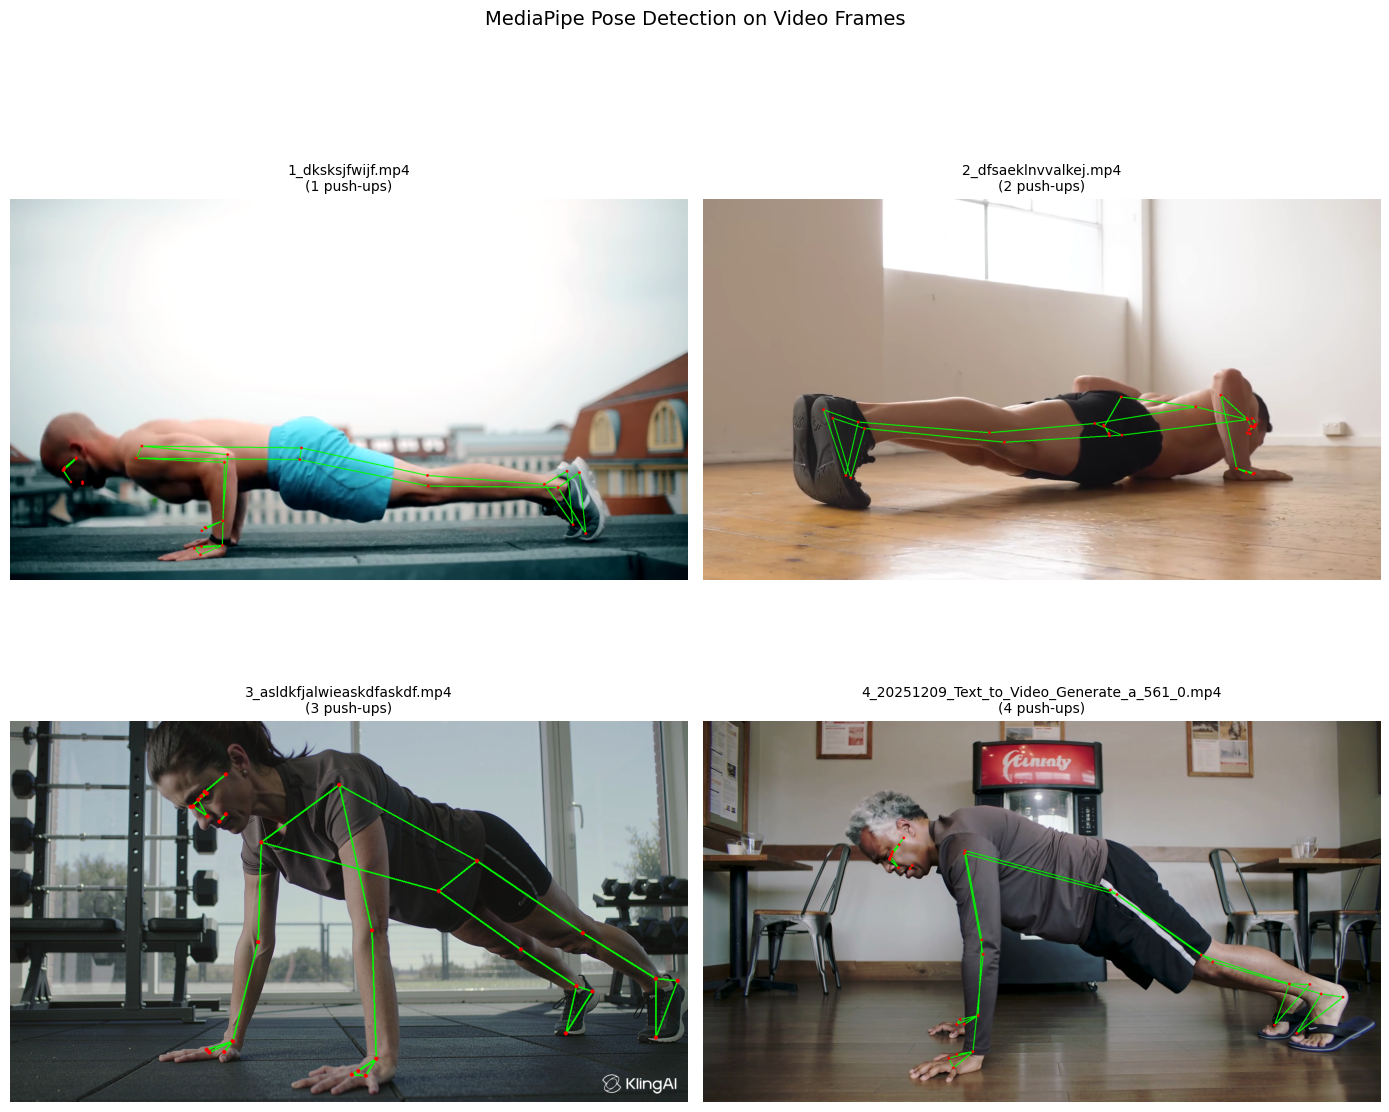

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (video_name, frame) in enumerate(frames.items()):
    if idx >= 4:
        break
    
    result = pose_results.get(video_name)
    annotated_frame = draw_landmarks(frame, result.pose_landmarks if result else None)
    
    ax = axes[idx]
    ax.imshow(annotated_frame)
    
    label = video_name.split('_')[0]
    ax.set_title(f"{video_name}\n({label} push-ups)", fontsize=10)
    ax.axis('off')

plt.suptitle("MediaPipe Pose Detection on Video Frames", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Landmark Legend

The skeleton overlay shows:
- **Red circles**: Individual landmark points (33 total)
- **Green lines**: Connections between landmarks forming the skeleton

Key landmarks used in push-up detection:
- Shoulders (indices 11, 12)
- Elbows (indices 13, 14)  
- Wrists (indices 15, 16)
- Hips (indices 23, 24)
- Knees (indices 25, 26)